<a href="https://colab.research.google.com/github/easy-min/IT_business/blob/main/ITB_subject2pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2020년도 건강검진정보 샘플(1만건) 데이터를 이용히야 최적의 분류 모델을 만들고 평가 결과 및 도출된 인사이트를 보여주시오. 

(1) 흥미로운 분류 문제 선정: 종속/독립 변수 선택 
   - 수치 데이터를 범주형으로 변경 가능 (예. 이진 클래스로 변경: 0.5 이상 Y, 0.5 미만 N)
   - 건강검진 데이터에 다른 외부 데이터를 연결해서 이용도 가능
   - 필요한 경우 데이터 전처리 및 파생변수 생성 

(2) 최적의 분류 모델 선택 (분류 기법, 파라미터) 및 평가 결과 
   - 적절한 평가 방법 1개 선택 
   - 분류 모델의 종류는 3개 이하로 선택, 수업시간에 배우지 않은 분류 모델도 사용 가능 

(3) 분류 모델을 통한 인사이트 도출:  중요 변수 설명 등  

(4) 코드는 github에 올리고 주소 제출

# 데이터 불러오기

In [1]:
! pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive #colab과 google drive 연결
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
%matplotlib inline
import matplotlib as mpl               # 기본 설정
import matplotlib.pyplot as plt        # 그래프 관련
import matplotlib.font_manager as fm   # 폰트 관련

mpl.rcParams['axes.unicode_minus'] = False  ## 마이너스 부호가 깨지는 것 방지 

!apt-get update -qq
!apt-get install fonts-nanum* -qq              # 나눔 폰트 설치

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)                                # 전체 폰트 개수

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}") # 나눔 폰트 개수 (설치된 것을 확인)
#nanum_font

# 설치된 나눔글꼴중 원하는 폰트의 전체 경로 가져오기 
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)
fm._rebuild()  # 폰트 적용

sys_font number: 48
['/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareEB.ttf', '/usr/share/fonts/truetype/nanum/NanumBrush.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundEB.t

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ITB/health_data.csv")
display(df.head())

,기준년도,가입자일련번호,시도코드,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석,데이터공개일자
0,2020,1,36,M,9,165,60,72.1,1.2,1.5,...,1.1,21.0,27.0,21.0,No,No,0,NaN,NaN,12/29/2021
1,2020,2,27,F,13,150,65,81.0,0.8,0.8,...,0.5,18.0,15.0,15.0,No,No,0,NaN,NaN,12/29/2021
2,2020,3,11,F,12,155,55,70.0,0.6,0.7,...,0.7,27.0,25.0,7.0,No,No,0,NaN,NaN,12/29/2021
3,2020,4,31,M,13,160,70,90.8,1.0,1.0,...,1.2,65.0,97.0,72.0,No,No,1,0.0,0.0,12/29/2021
4,2020,5,41,F,12,155,50,75.2,1.5,1.2,...,0.7,18.0,17.0,14.0,No,No,0,NaN,NaN,12/29/2021


# 데이터 전처리

In [6]:
# 변수명 변경
df = df.rename(columns = {'기준년도': 'YEAR'})
df = df.rename(columns = {'시도코드': 'SIDO'})
df = df.rename(columns= {'성별코드': 'SEX'})
df = df.rename(columns = {'연령대코드(5세단위)': 'AGE_GROUP'})
df = df.rename(columns = {'신장(5Cm단위)': 'HEIGHT'})
df = df.rename(columns = {'체중(5Kg 단위)': 'WEIGHT'})
df = df.rename(columns = {'허리둘레': 'WAIST'})

#df = df.rename(columns = {'시력(좌)': 'SIGHT_LEFT'})
#df = df.rename(columns = {'시력(우)': 'SIGHT_RIGHT'})
#df = df.rename(columns = {'수축기혈압': 'BP_HIGH'})
#df = df.rename(columns = {'이완기혈압': 'BP_LWST'})
#df = df.rename(columns = {'식전혈당(공복혈당)': 'BLDS'})
#df = df.rename(columns = {'총콜레스테롤': 'TOT_CHOLE'})
#df = df.rename(columns = {'트리글리세라이드': 'TRIGLYCERIDE'})
#df = df.rename(columns = {'HDL콜레스테롤': 'HDL_CHOLE'})
#df = df.rename(columns = {'LDL콜레스테롤': 'LDL_CHOLE'})
#df = df.rename(columns = {'혈색소': 'HMG'})


In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   YEAR        10000 non-null  int64  
 1   가입자일련번호     10000 non-null  int64  
 2   SIDO        10000 non-null  int64  
 3   SEX         10000 non-null  object 
 4   AGE_GROUP   10000 non-null  int64  
 5   HEIGHT      10000 non-null  int64  
 6   WEIGHT      10000 non-null  int64  
 7   WAIST       10000 non-null  float64
 8   시력(좌)       10000 non-null  float64
 9   시력(우)       10000 non-null  float64
 10  청력(좌)       10000 non-null  int64  
 11  청력(우)       10000 non-null  int64  
 12  수축기혈압       9912 non-null   float64
 13  이완기혈압       9912 non-null   float64
 14  식전혈당(공복혈당)  9912 non-null   float64
 15  총콜레스테롤      4044 non-null   float64
 16  트리글리세라이드    4044 non-null   float64
 17  HDL콜레스테롤    4044 non-null   float64
 18  LDL콜레스테롤    3977 non-null   float64
 19  혈색소         9912 non-null 

None

In [8]:
display(df.isna().sum()) # 결측치 수

YEAR             0
가입자일련번호          0
SIDO             0
SEX              0
AGE_GROUP        0
HEIGHT           0
WEIGHT           0
WAIST            0
시력(좌)            0
시력(우)            0
청력(좌)            0
청력(우)            0
수축기혈압           88
이완기혈압           88
식전혈당(공복혈당)      88
총콜레스테롤        5956
트리글리세라이드      5956
HDL콜레스테롤      5956
LDL콜레스테롤      6023
혈색소             88
요단백            139
혈청크레아티닌         88
(혈청지오티)AST      88
(혈청지오티)ALT      88
감마지티피           88
흡연상태             2
음주여부             1
구강검진수검여부         0
치아우식증유무       6749
치석            6749
데이터공개일자          0
dtype: int64

다음 아래의 변수들은 전체 데이터의 50%가 넘게 결측치가 발생했으므로, 분석에서 제외

총콜레스테롤        5956

트리글리세라이드      5956

HDL콜레스테롤      5956

LDL콜레스테롤      6023

치아우식증유무       6749

치석            6749

In [9]:
df.columns

Index(['YEAR', '가입자일련번호', 'SIDO', 'SEX', 'AGE_GROUP', 'HEIGHT', 'WEIGHT',
       'WAIST', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압',
       '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소',
       '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부',
       '구강검진수검여부', '치아우식증유무', '치석', '데이터공개일자'],
      dtype='object')

In [10]:
df1 = df[['YEAR', 'SIDO', 'SEX', 'AGE_GROUP', 'HEIGHT', 'WEIGHT', 'WAIST', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',  '혈색소','요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부','구강검진수검여부']]

In [11]:
display(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   YEAR        10000 non-null  int64  
 1   SIDO        10000 non-null  int64  
 2   SEX         10000 non-null  object 
 3   AGE_GROUP   10000 non-null  int64  
 4   HEIGHT      10000 non-null  int64  
 5   WEIGHT      10000 non-null  int64  
 6   WAIST       10000 non-null  float64
 7   시력(좌)       10000 non-null  float64
 8   시력(우)       10000 non-null  float64
 9   청력(좌)       10000 non-null  int64  
 10  청력(우)       10000 non-null  int64  
 11  수축기혈압       9912 non-null   float64
 12  이완기혈압       9912 non-null   float64
 13  식전혈당(공복혈당)  9912 non-null   float64
 14  혈색소         9912 non-null   float64
 15  요단백         9861 non-null   float64
 16  혈청크레아티닌     9912 non-null   float64
 17  (혈청지오티)AST  9912 non-null   float64
 18  (혈청지오티)ALT  9912 non-null   float64
 19  감마지티피       9912 non-null 

None

In [12]:
# df1에서 NAN값은 작으므로 역시 삭제 (이 때 최대한으로 데이터를 삭제할 수 있도록 일부 행 삭제)
df1 = df1.dropna(subset = ['수축기혈압', '이완기혈압', '요단백', '흡연상태', '음주여부'], axis=0) 

display(df1.isna().sum()) # 결측치 수

YEAR          0
SIDO          0
SEX           0
AGE_GROUP     0
HEIGHT        0
WEIGHT        0
WAIST         0
시력(좌)         0
시력(우)         0
청력(좌)         0
청력(우)         0
수축기혈압         0
이완기혈압         0
식전혈당(공복혈당)    0
혈색소           0
요단백           0
혈청크레아티닌       0
(혈청지오티)AST    0
(혈청지오티)ALT    0
감마지티피         0
흡연상태          0
음주여부          0
구강검진수검여부      0
dtype: int64

In [13]:
display(df1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9858 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   YEAR        9858 non-null   int64  
 1   SIDO        9858 non-null   int64  
 2   SEX         9858 non-null   object 
 3   AGE_GROUP   9858 non-null   int64  
 4   HEIGHT      9858 non-null   int64  
 5   WEIGHT      9858 non-null   int64  
 6   WAIST       9858 non-null   float64
 7   시력(좌)       9858 non-null   float64
 8   시력(우)       9858 non-null   float64
 9   청력(좌)       9858 non-null   int64  
 10  청력(우)       9858 non-null   int64  
 11  수축기혈압       9858 non-null   float64
 12  이완기혈압       9858 non-null   float64
 13  식전혈당(공복혈당)  9858 non-null   float64
 14  혈색소         9858 non-null   float64
 15  요단백         9858 non-null   float64
 16  혈청크레아티닌     9858 non-null   float64
 17  (혈청지오티)AST  9858 non-null   float64
 18  (혈청지오티)ALT  9858 non-null   float64
 19  감마지티피       9858 non-null  

None

# 분류 목적

혈색소는 빈혈과 연관된 중요한 수치 중에 하나이다. 다음은 대한진단검사의학회의 자료이다.

-----------------------------------------------------------------
혈색소의 양을 측정함으로써 혈액의 능력을 알 수 있는데, 산소가 조직과 장기로 잘 운반되고 있는지, 노폐물인 이산화탄소 (폐에서 배출됨) 가 폐로 잘 운반되고 있는지 알아낼 수 있습니다. 환자의 혈색소 수치가 낮으면 빈혈이 있을 가능성이 있는데, 빈혈이란 몸에 산소가 부족하여, 피로감과 쇠약감을 일으키는 상태입니다.

혈색소 수치는 적혈구수가 증가될 때 상승합니다. 혈색소치가 정상보다 아래로 떨어지면 빈혈을 의미하며, 체내에서 적혈구의 생산량이 감소하거나 적혈구 파괴가 증가하거나 출혈로 인해 피가 손실될 때 발생한다.

-----------------------------------------------------------------
이 때 성인의 정상치는 데시리터(100밀리리터) 당 12그램에서 18그램이므로, 혈색소가12그램을 넘지 않을 때 (N), 넘을 경우 (Y)로 하는 새로운 변수(ANEMIA)를 만들어 파악하고자 한다.

In [14]:
df1['ANEMIA'] = df['혈색소'].apply(lambda x : "N" if x <12 else "Y")

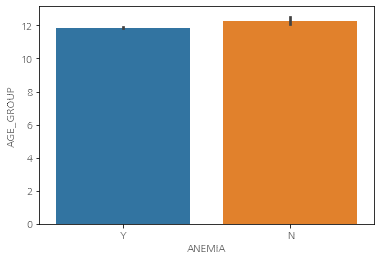

In [15]:
sns.barplot(x="ANEMIA", y="AGE_GROUP",data=df1)

In [16]:
df1.head #파생변수 확인

<bound method NDFrame.head of       YEAR  SIDO SEX  AGE_GROUP  HEIGHT  WEIGHT  WAIST  시력(좌)  시력(우)  청력(좌)  \
0     2020    36   M          9     165      60   72.1    1.2    1.5      1   
1     2020    27   F         13     150      65   81.0    0.8    0.8      1   
2     2020    11   F         12     155      55   70.0    0.6    0.7      1   
3     2020    31   M         13     160      70   90.8    1.0    1.0      1   
4     2020    41   F         12     155      50   75.2    1.5    1.2      1   
...    ...   ...  ..        ...     ...     ...    ...    ...    ...    ...   
9994  2020    41   M         17     150      55   95.0    0.5    0.8      1   
9995  2020    44   F         13     155      55   83.0    1.2    1.2      1   
9996  2020    43   F         11     160      55   77.5    1.0    1.2      1   
9997  2020    45   M         12     160      80   93.0    0.6    0.6      1   
9999  2020    45   F         13     160      75  100.0    0.5    0.5      1   

      ...   혈색소  요단백 

In [17]:
df1 = df1.replace({'No':1, 'Yes':2, 'NotNow': 3})
df1 = df1.replace({'M':1, 'F': 2})
df1 = df1.drop(labels='혈색소',axis=1)
df1

,YEAR,SIDO,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,시력(좌),시력(우),청력(좌),...,식전혈당(공복혈당),요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,ANEMIA
0,2020,36,1,9,165,60,72.1,1.2,1.5,1,...,90.0,1.0,1.1,21.0,27.0,21.0,1,1,0,Y
1,2020,27,2,13,150,65,81.0,0.8,0.8,1,...,87.0,1.0,0.5,18.0,15.0,15.0,1,1,0,Y
2,2020,11,2,12,155,55,70.0,0.6,0.7,1,...,102.0,1.0,0.7,27.0,25.0,7.0,1,1,0,Y
3,2020,31,1,13,160,70,90.8,1.0,1.0,1,...,146.0,1.0,1.2,65.0,97.0,72.0,1,1,1,Y
4,2020,41,2,12,155,50,75.2,1.5,1.2,1,...,110.0,1.0,0.7,18.0,17.0,14.0,1,1,0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2020,41,1,17,150,55,95.0,0.5,0.8,1,...,115.0,1.0,1.1,22.0,21.0,18.0,1,1,0,Y
9995,2020,44,2,13,155,55,83.0,1.2,1.2,1,...,120.0,1.0,0.7,20.0,21.0,20.0,1,2,0,Y
9996,2020,43,2,11,160,55,77.5,1.0,1.2,1,...,117.0,1.0,0.7,24.0,22.0,21.0,1,2,1,Y
9997,2020,45,1,12,160,80,93.0,0.6,0.6,1,...,86.0,1.0,1.0,22.0,27.0,35.0,1,1,0,Y


In [18]:
df1.columns

Index(['YEAR', 'SIDO', 'SEX', 'AGE_GROUP', 'HEIGHT', 'WEIGHT', 'WAIST',
       '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
       '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부',
       '구강검진수검여부', 'ANEMIA'],
      dtype='object')

In [19]:
df1 = df1[['ANEMIA', 'YEAR', 'SIDO', 'SEX', 'AGE_GROUP', 'HEIGHT', 'WEIGHT', 'WAIST', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', 
           '식전혈당(공복혈당)', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', '음주여부', '구강검진수검여부']]

# [1]  의사결정나무

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [21]:
X = df1.iloc[:, 1:]  # 21개 변수 
y = df1['ANEMIA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [58]:
tree = DecisionTreeClassifier(random_state=0)  

tree.fit(X_train, y_train) #학습한다는 뜻
print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))

학습용 데이터 정확도: 1.000
시험용 데이터 정확도: 0.888


In [59]:
# 의사결정나무의 깊이를 10로 제한
# 과적합(overfitting): 학습용 데이터에 대해서만 성능이 좋고 새로운 데이터에 적용했을 경우에는 성능이 좋지 않은 경우
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(X_train, y_train)

print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))

학습용 데이터 정확도: 0.962
시험용 데이터 정확도: 0.919


In [24]:
# 의사결정나무의 깊이를 20로 제한
# 과적합(overfitting): 학습용 데이터에 대해서만 성능이 좋고 새로운 데이터에 적용했을 경우에는 성능이 좋지 않은 경우
tree = DecisionTreeClassifier(max_depth=20, random_state=0)
tree.fit(X_train, y_train)

print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))

학습용 데이터 정확도: 0.996
시험용 데이터 정확도: 0.890


In [25]:
#graphviz 라이브러리를 이용하여 의사결정나무 그리기 
from sklearn.tree import export_graphviz
import graphviz

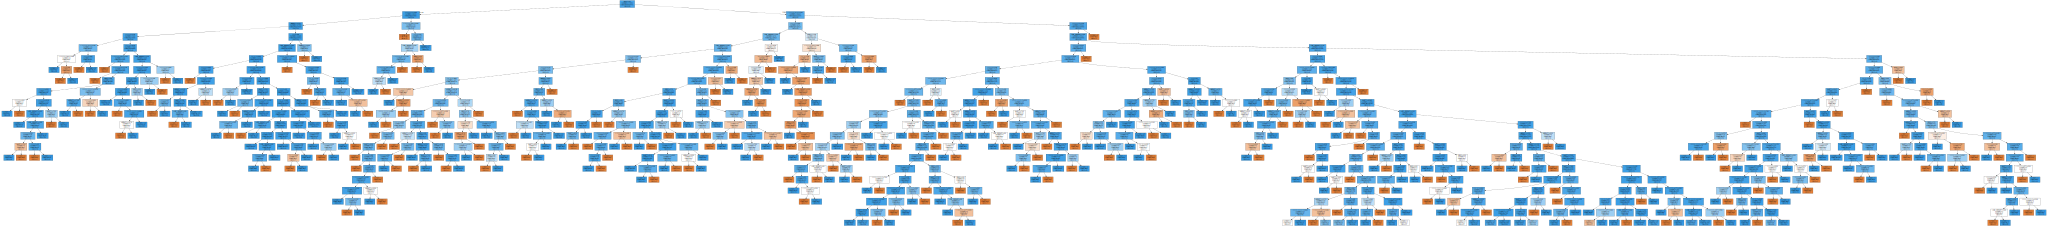

In [26]:
# filled = True: 색상의 진하기로 클래스를 나타냄, impurity: 불순도 계산값 보여주기 옵션
### export_graphviz(tree(tree 넣어야 함), out_file="tree.dot", class_names=[ (왼쪽)"양성", (오른쪽)"악성"],
###             feature_names=wisc.columns[1:], impurity=False, filled=True)

export_graphviz(tree, out_file="tree.dot", class_names=[ 'Y', 'N'],
                feature_names=df1.columns[1:], impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

In [27]:
result = tree.feature_importances_
print("변수의 중요도:\n", result)

변수의 중요도:
 [0.         0.06838848 0.04375678 0.05427156 0.04517146 0.03838132
 0.08406943 0.05613945 0.05878861 0.01383291 0.00229602 0.07142109
 0.06518138 0.0690466  0.0058752  0.0614334  0.06450923 0.07632912
 0.09143309 0.0128747  0.00536176 0.0114384 ]


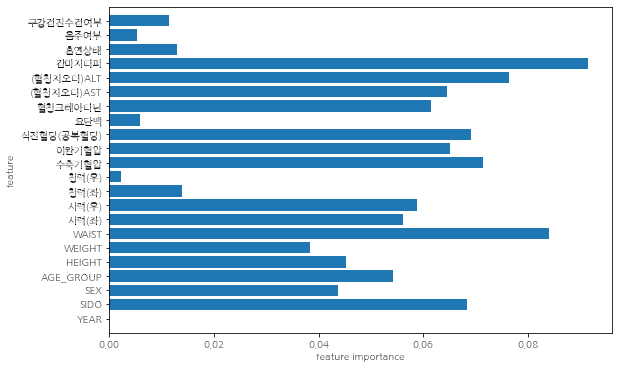

In [28]:
import numpy as np

def plot_feature_importances_wisc(model):
    plt.rcParams["figure.figsize"] = (9,6)
    n_features = len(df1.columns[1:])  # 'ANEMIA'를 제외한 나머지'
    plt.barh(np.arange(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), df1.columns[1:])   # 눈금을 표시하고 눈금 레이블을 변수 이름으로 지정
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features) #Y 축 범위 지정

plot_feature_importances_wisc(tree)

In [80]:
res = pd.DataFrame(result)
res["name"] = df1.columns[1:]
display(res.info())

# perimeter_worst의 비중이 가장 큼, 루트 노드에서 이 값부터 사용 
res.sort_values(0, ascending = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       22 non-null     float64
 1   name    22 non-null     object 
dtypes: float64(1), object(1)
memory usage: 480.0+ bytes


None

,0,name
18,0.091433,감마지티피
6,0.084069,WAIST
17,0.076329,(혈청지오티)ALT
11,0.071421,수축기혈압
13,0.069047,식전혈당(공복혈당)
1,0.068388,SIDO
12,0.065181,이완기혈압
16,0.064509,(혈청지오티)AST
15,0.061433,혈청크레아티닌
8,0.058789,시력(우)


# [2] 랜덤포레스트

In [30]:
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import mglearn

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


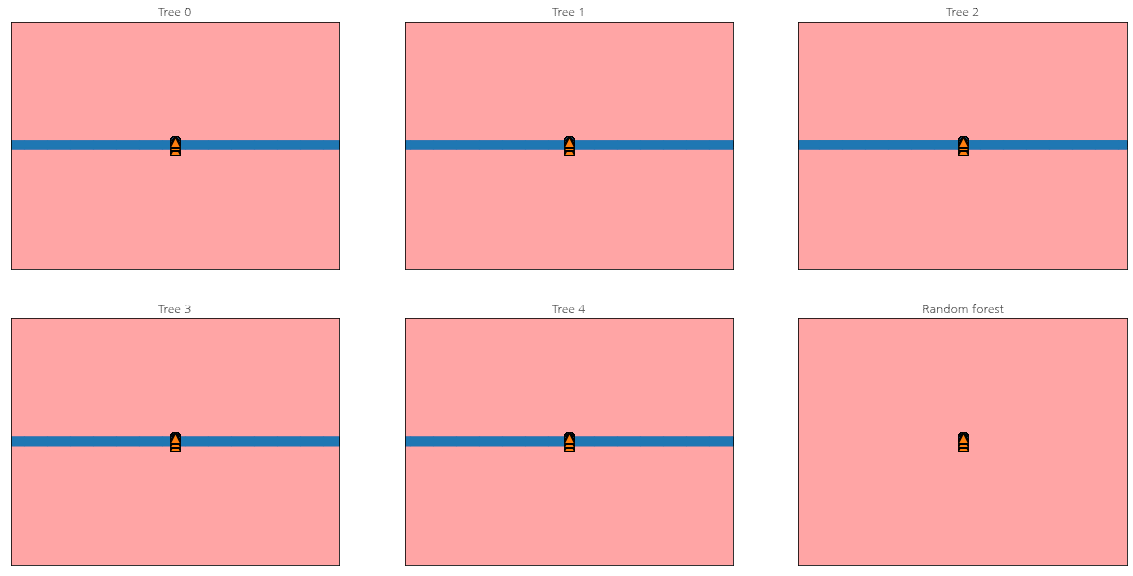

In [33]:
from sklearn.ensemble import RandomForestClassifier

# radius_mean, texture_mean 변수만 이용하여 
# 5개의 나무를 만드는 예 (n_estimators = 5, 실제는 수백개의 트리를 만든다)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train.iloc[:, 0:2], y_train)

# 5개 나무 각각의 분류 경계를 그림 (서로 모양이 많이 다르다)
# 2차원으로 나무의 결과를 보여주기 위한 코드로 mglearn의 함수들을 이용 - 여기서는 설명 생략
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X.iloc[:, 0:2].values, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X.iloc[:, 0:2].values, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random forest")
mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y)
plt.show()

In [34]:
# 21개 변수를 모두 이용하여 100개의 나무 생성 (정확도가 높아짐)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

학습용 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.933


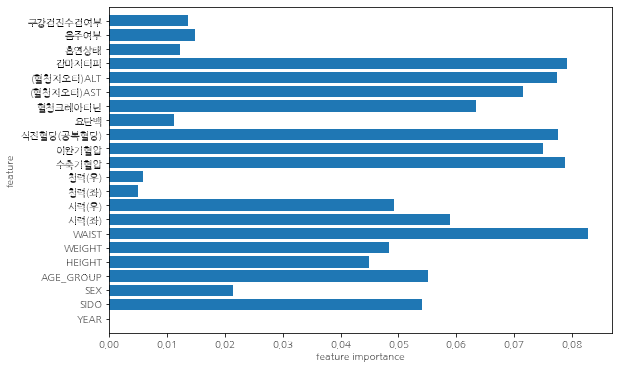

In [35]:
# 단일 의사결정나무의 경우보다 많은 변수(feature)들이 사용됨
plot_feature_importances_wisc(forest)

In [36]:
from sklearn.model_selection import cross_val_score

# 교차 검증을 10번 수행하여 10번의 교차 검증 평균 정확도를 비교 (10-fold cross validation)
# default cv=5

dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 

Accuracy
Decision tree:  [0.9027027  0.8972973  0.88243243 0.87956698 0.89580514 0.8985115
 0.89445196 0.89309878 0.88633288 0.89580514]
Random forest:  [0.93918919 0.94054054 0.93783784 0.94046008 0.94316644 0.93775372
 0.9391069  0.94046008 0.94046008 0.9391069 ]
Accuracy mean
Decision tree :0.893
Random forest :0.940


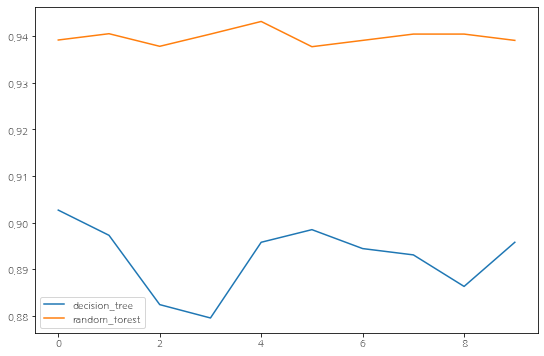

In [37]:
cv_list = [    
            ['decision_tree',dt_scores],
            ['random_forest',rf_scores],
          ]
df = pd.DataFrame.from_dict(dict(cv_list))
df.plot()

# [3] 그래디언트 부스팅

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
# 기본값은 max_depth= 3, n_estimators=100, learning_rate = 0.1

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [39]:
print("학습용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

학습용 데이터 세트 정확도: 0.948
시험용 데이터 세트 정확도: 0.932


In [40]:
#나무 깊이 제한
gbrt = GradientBoostingClassifier(random_state=0, max_depth=10)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

학습 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.931


In [41]:
#학습률 감소
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

학습 데이터 세트 정확도: 0.940
시험용 데이터 세트 정확도: 0.932


In [49]:
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=10, scoring='accuracy')

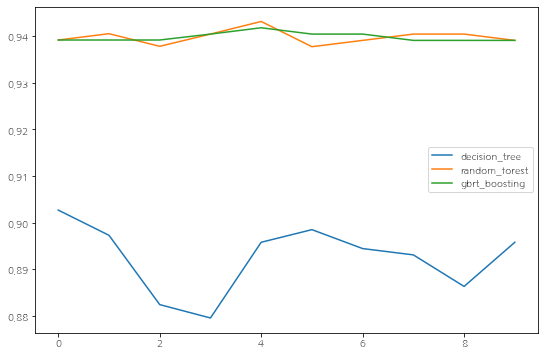

In [50]:
cv_list = [    
            ['decision_tree',dt_scores],
            ['random_forest',rf_scores],
           ['gbrt_boosting',gbrt_scores],
          ]
df2 = pd.DataFrame.from_dict(dict(cv_list))
df2.plot()

# 평가

## [1] 교차검증

In [43]:
# 교차 검증을 10번 수행하여 10번의 교차 검증 평균 정확도를 비교 (10-fold cross validation)
# default cv=5

dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 
print("Gradient boosting: ", gbrt_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 

Accuracy
Decision tree:  [0.9027027  0.8972973  0.88243243 0.87956698 0.89580514 0.8985115
 0.89445196 0.89309878 0.88633288 0.89580514]
Random forest:  [0.93918919 0.94054054 0.93783784 0.94046008 0.94316644 0.93775372
 0.9391069  0.94046008 0.94046008 0.9391069 ]
Gradient boosting:  [0.93918919 0.93918919 0.93918919 0.94046008 0.94181326 0.94046008
 0.94046008 0.9391069  0.9391069  0.9391069 ]
Accuracy mean
Decision tree :0.893
Random forest :0.940
Gradient boosting :0.940


In [44]:
# 교차 검증 상세 옵션 지정

# KFold :기본값 n_splits=5, shuffle=None (데이터를 임의로 섞지 않음) 
# LeaveOneOut :데이터 1개를 검증에 이용 
# ShuffleSplit :임의 분할, 전체 데이터를 모두 사용하지 않을 수도 있음
# GroupKFold :그룹을 지정해서 같은 그룹의 데이터는 학습용 또는 검증용으로 동일하게 분할
# StratifiedKFold :각 fold마다 클래스의 분포가 동일하도록 분할 (예. N, Y) 
# RepeatedStratifiedKFold: 교차검증을 반복, 기본값 n_repeats =10

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10)
#from sklearn.model_selection import RepeatedStratifiedKFold
#kf = RepeatedStratifiedKFold(n_splits=10)

print(kf)

dt_scores = cross_val_score(tree, X_train, y_train, cv=kf, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=kf, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=kf, scoring='accuracy')

print("Accuracy mean -- StratifiedKFold 이용")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
Accuracy mean -- StratifiedKFold 이용
Decision tree :0.893
Random forest :0.940
Gradient boosting :0.940


## [2] 그리드 서치

In [46]:
from sklearn.model_selection import GridSearchCV

# 파라미터를 dictionary 형태로 설정
parameters = {'max_depth':[3,5,7, 9, 11], 'learning_rate':[0.2, 0.1, 0.08, 0.06, 0.04, 0.02]}

In [47]:
# param_grid의 파라미터들을 3개의 fold 로 나누어 검증
# refit=True (기본값): 가장 좋은 파라미터 설정으로 재학습  
init_gbrt = GradientBoostingClassifier(random_state=0)
grid_gbrt = GridSearchCV(init_gbrt, param_grid=parameters, cv=3, refit=True)
print(grid_gbrt)
# 파라미터들을 순차적으로 학습, 검증
grid_gbrt.fit(X_train, y_train)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_gbrt.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']]

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.2, 0.1, 0.08, 0.06, 0.04, 0.02],
                         'max_depth': [3, 5, 7, 9, 11]})


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': 0.2, 'max_depth': 3}",0.935885,26,0.938337,0.936688,0.932630
1,"{'learning_rate': 0.2, 'max_depth': 5}",0.932774,30,0.931846,0.933847,0.932630
2,"{'learning_rate': 0.2, 'max_depth': 7}",0.935885,24,0.935091,0.937094,0.935471
3,"{'learning_rate': 0.2, 'max_depth': 9}",0.937508,13,0.938742,0.938312,0.935471
4,"{'learning_rate': 0.2, 'max_depth': 11}",0.937914,11,0.939959,0.938718,0.935065
5,"{'learning_rate': 0.1, 'max_depth': 3}",0.939808,5,0.939148,0.941153,0.939123
6,"{'learning_rate': 0.1, 'max_depth': 5}",0.936967,17,0.937120,0.937906,0.935877
7,"{'learning_rate': 0.1, 'max_depth': 7}",0.935885,25,0.937120,0.935471,0.935065
8,"{'learning_rate': 0.1, 'max_depth': 9}",0.937238,15,0.939959,0.936688,0.935065
9,"{'learning_rate': 0.1, 'max_depth': 11}",0.937237,16,0.940771,0.937094,0.933847


In [51]:
print('GridSearchCV 최적 파라미터:', grid_gbrt.best_params_) #하나만 알아도 된다.
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_gbrt.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.06, 'max_depth': 5}
GridSearchCV 최고 정확도: 0.9408


In [52]:
# 최적 파라미터로 학습이 된 모델을 이용하여 시험용 데이터 세트 분류
print("시험용 데이터 세트 정확도: {:.3f}".format(grid_gbrt.score(X_test, y_test)))

시험용 데이터 세트 정확도: 0.933


## [3] 정오분류표

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 

print(y_test.value_counts()) # y_test 의 B,M 분포

Y    2298
N     167
Name: ANEMIA, dtype: int64


In [60]:
dt_pred = tree.predict(X_test)
rf_pred = forest.predict(X_test)
grid_gbrt_pred = grid_gbrt.predict(X_test)

# 예측 결과인 pred와 실제 결과인 y_test의 Confusion Matrix 출력
print('Decision tree 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, dt_pred)))
print(confusion_matrix(y_test, dt_pred))
print('Random forest 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, rf_pred)))
print(confusion_matrix(y_test, rf_pred))
print('Gradient boosting 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, grid_gbrt_pred)))
print(confusion_matrix(y_test, grid_gbrt_pred))

Decision tree 시험용 데이터 세트 정확도:0.919
[[  17  150]
 [  49 2249]]
Random forest 시험용 데이터 세트 정확도:0.933
[[   5  162]
 [   4 2294]]
Gradient boosting 시험용 데이터 세트 정확도:0.933
[[  13  154]
 [  10 2288]]


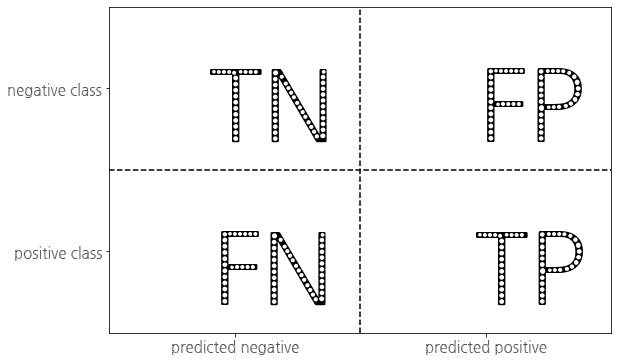

In [61]:
mglearn.plots.plot_binary_confusion_matrix()

In [63]:
print('정밀도:{:.3f}'.format(precision_score (y_test, grid_gbrt_pred, average='binary', pos_label="N")))  # pos_label = 1 기본값
print('TP (49) / TP+FP (52) = {:.3f}'.format(49/52))
print('재현율:{:.3f}'.format(recall_score(y_test, grid_gbrt_pred, average='binary', pos_label="N")))
print('TP (49) / TP+FN (51) = {:.3f}'.format(49/51))
print('f1-measure:{:.3f}'.format(f1_score(y_test, grid_gbrt_pred, average='binary', pos_label="N")))
print('2*(정밀도*재현율)/(정밀도+재현율) = {:.3f}'.format(2*0.942*0.961/(0.942+0.961)))

정밀도:0.565
TP (49) / TP+FP (52) = 0.942
재현율:0.078
TP (49) / TP+FN (51) = 0.961
f1-measure:0.137
2*(정밀도*재현율)/(정밀도+재현율) = 0.951


In [64]:
from sklearn.metrics import classification_report

# 각 클래스가 Positive일 때의 정밀도, 재현율, f1 값을 보여줌 ("N"인 경우가 기본값임)
# macro avg는 클래스별 점수의 평균을 계산
# weighted avg는 클래스의 샘플 수로 가중평균을 계산
print("Decision Tree:")
print(classification_report(y_test, dt_pred, target_names=["N", "Y"]))
print("Random Forest:")
print(classification_report(y_test, rf_pred, target_names=["N", "Y"]))
print("Gradient Boosting:")
print(classification_report(y_test, grid_gbrt_pred, target_names=["N", "Y"]))

Decision Tree:
              precision    recall  f1-score   support

           N       0.26      0.10      0.15       167
           Y       0.94      0.98      0.96      2298

    accuracy                           0.92      2465
   macro avg       0.60      0.54      0.55      2465
weighted avg       0.89      0.92      0.90      2465

Random Forest:
              precision    recall  f1-score   support

           N       0.56      0.03      0.06       167
           Y       0.93      1.00      0.97      2298

    accuracy                           0.93      2465
   macro avg       0.74      0.51      0.51      2465
weighted avg       0.91      0.93      0.90      2465

Gradient Boosting:
              precision    recall  f1-score   support

           N       0.57      0.08      0.14       167
           Y       0.94      1.00      0.97      2298

    accuracy                           0.93      2465
   macro avg       0.75      0.54      0.55      2465
weighted avg       0.91  

## [4] ROC

[[0.00000000e+00 1.00000000e+00]
 [4.97265042e-04 9.99502735e-01]
 [4.97265042e-04 9.99502735e-01]
 ...
 [4.52625226e-02 9.54737477e-01]
 [4.52625226e-02 9.54737477e-01]
 [4.52625226e-02 9.54737477e-01]]


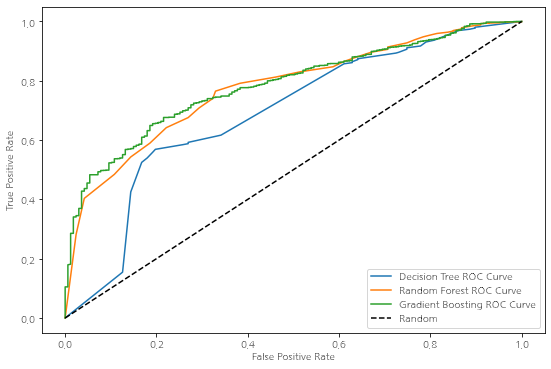

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve

print(tree.predict_proba(X_test))

fpr_dt, tpr_dt, cutoff_dt = roc_curve(y_test, tree.predict_proba(X_test)[:, 1], pos_label="Y")
fpr_rf, tpr_rf, cutoff_rf = roc_curve(y_test, forest.predict_proba(X_test)[:, 1], pos_label="Y")
fpr_gbrt, tpr_gbrt, cutoff_gbrt = roc_curve(y_test, grid_gbrt.predict_proba(X_test)[:, 1], pos_label="Y")

plt.plot(fpr_dt, tpr_dt, label="Decision Tree ROC Curve")
plt.plot(fpr_rf, tpr_rf, label="Random Forest ROC Curve")
plt.plot(fpr_gbrt, tpr_gbrt, label="Gradient Boosting ROC Curve")
plt.plot([0,1], [0, 1], "k--", label ="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc=4)
plt.show() 

In [70]:
auc_dt = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
auc_gbrt = roc_auc_score(y_test, grid_gbrt.predict_proba(X_test)[:, 1])
print("Decision Tree의 AUC: {:.3f}".format(auc_dt))
print("Random Forest의 AUC: {:.3f}".format(auc_rf))
print("Gradient Boosting의 AUC: {:.3f}".format(auc_gbrt)) ## AUC 면적이 가장 큰 모델

Decision Tree의 AUC: 0.690
Random Forest의 AUC: 0.776
Gradient Boosting의 AUC: 0.784


# 결론

성인의 정상치는 데시리터(100밀리리터) 당 12그램에서 18그램이므로, 혈색소가12그램을 넘지 않을 때 (N), 넘을 경우 (Y)로 하는 새로운 변수(ANEMIA)라고 정의하고, 해당 컬럼과 관련된 주요 변수는 무엇이 있을지 확인했다.

이 때 분류 모델로는 의사결정나무, 랜덤포레스트, 그래디언트 부스팅 등을 활용했다.



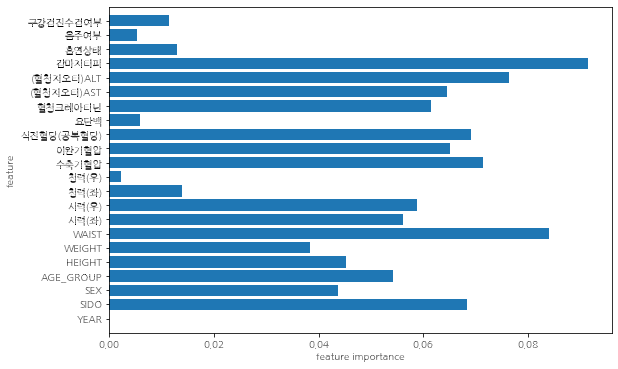

분석결과, 빈혈과 관련있는 변수는 다음과 같다.
따라서 다음과 같은 변수를 참고해 감마티지, 허리둘레, (혈청지오티)ALT, 수축기 혈압이 높은 경우 빈혈을 의심할 필요가 있다.

18	0.091433	감마지티피

---------------------------------
6	0.084069	WAIST

--------------------------------
17	0.076329	(혈청지오티)ALT

11	0.071421	수축기혈압

--------------------------------
13	0.069047	식전혈당(공복혈당)

1	0.068388	SIDO

12	0.065181	이완기혈압

16	0.064509	(혈청지오티)AST

15	0.061433	혈청크레아티닌

--------------------------------
8	0.058789	시력(우)

7	0.056139	시력(좌)

3	0.054272	AGE_GROUP



- 감마티피지가 관련이 높은 것으로 나와 있는데, 학술지를 통해 감마 지티피(γ-GTP)란 간, 신장, 췌장, 비장, 심장, 뇌에 분포하는 효소다. 조직의 세포막에 존재하여 질병을 방어하는 역할을 하는 것을 의미하며, 빈혈을 시사하는 군에서 혈중 감마지티피가 약간 높은 반응을 보인다는 것을 확인했다.

- 몸무게 대신, 허리둘레가 주요한 변수로 나왔는데, 혹시 정규화를 하지 못해 발생한 이상현상인지 추후 확인할 필요가 있다.

- 이완기 혈압보다는 수축기 혈압이 더 주요한 변수로 생각되어진다.

- 특이하게 "시도"가 주요 변수 중 하나로 뽑혔는데, 수치형자료로 해석되어 발생한 결과인지 확인할 필요가 있다.

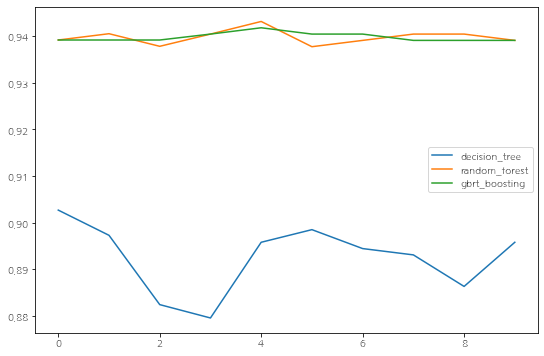

정확도는 의사결정나무에 비해 랜덤포레스트나 그래디언트 부스팅이 높은 수치를 보여주고 있다. 둘은 교차검증을 수행할 때마다 조금씩 우위가 바뀌고, 평균이 같기 때문에 다른 지표를 확인할 필요가 있다.

Decision tree :0.893
Random forest :0.940
Gradient boosting :0.940

그리드 서치로 나타난 최적의 파라미터는 다음과 같다.

GridSearchCV 최적 파라미터: {'learning_rate': 0.06, 'max_depth': 5}
GridSearchCV 최고 정확도: 0.9408

Decision Tree:
              precision    recall  f1-score   support

           N       0.26      0.10      0.15       167
           Y       0.94      0.98      0.96      2298

    accuracy                           0.92      2465
   macro avg       0.60      0.54      0.55      2465
weighted avg       0.89      0.92      0.90      2465

Random Forest:
              precision    recall  f1-score   support

           N       0.56      0.03      0.06       167
           Y       0.93      1.00      0.97      2298

    accuracy                           0.93      2465
   macro avg       0.74      0.51      0.51      2465
weighted avg       0.91      0.93      0.90      2465

Gradient Boosting:
              precision    recall  f1-score   support

           N       0.57      0.08      0.14       167
           Y       0.94      1.00      0.97      2298

    accuracy                           0.93      2465
   macro avg       0.75      0.54      0.55      2465
weighted avg       0.91      0.93      0.91      2465

랜덤포레스트는 정밀도가 높고, 그래디언트부스팅은 재현율이 높다. 이 때 빈혈을 모르고 지나치는 것보다 검사를 통해 정확한 빈혈수치를 알아내는 것이 더 가치가 높으므로, 재현율이 더 집중하는 것이 좋다. 또한 f1-measure도 그래디언트 부스팅이 높다.

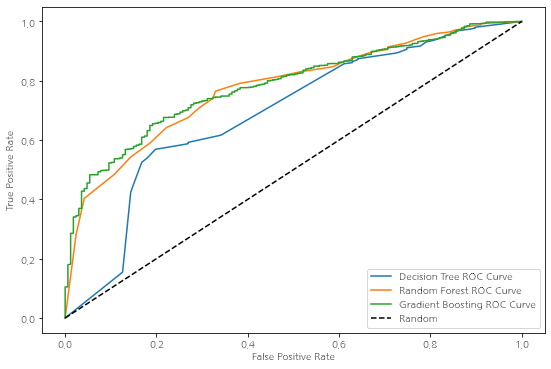

Decision Tree의 AUC: 0.690
Random Forest의 AUC: 0.776
Gradient Boosting의 AUC: 0.784

ROC 그래프에서 또한 Gradient Boosting의 AUC 면적이 0.08정도 더 높다. 따라서 그래디언트부스팅을 활용하는 것이 바람직하다.